#  Tuesday Meeting 
### [RN] 2/9/2021

I will start seeing if I can add a herd immunity extension to my SIR model. 

First I want to fit my SIR model against data. 

I am doing this before the meeting today at 12. 

I am going to copy and paste code from 20210202_TuesdayMeeting to extract raw data


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

In [2]:
### code from 20210202_TuesdayMeeting to get raw data into arrays. 

def ReadFile(infile): # read infile, return contents list of each line
    read = open(infile, 'r')
    lines = read.readlines()
    read.close()
    return(lines)
# read raw data
raw = ReadFile("USA-California.tsv")

def TryFloat(val): # I want to convert nonempty data points to either floats or none so I can operate on these arrays. 
    try:
        val = float(val)
    except:
        val = None
    return val
        
# extract data 
date, cases, deaths, hospital, icu, recovered = [], [], [], [], [], []

for i in range(4, len(raw)): # split up raw data. it looks like there are bytes  b'\t' that seprate vals in addition to end characters. 
    thisset = raw[i]
    thisset = thisset.encode('utf-8') # encode data as bytes
    working = thisset.split(b'\t') # split data by byte
    for i in range(len(working)):
        working[i] = working[i].decode('utf8', 'strict') # put back as string for easier handling 
    date.append(working[0])
    cases.append(TryFloat(working[1]))
    deaths.append(TryFloat(working[2]))
    hospital.append(TryFloat(working[3]))
    icu.append(TryFloat(working[4]))
    recovered.append(working[5])



In [3]:
#### My SIR function that I checked last friday

def SIR_noR0(I0, N, k, g, dt, duration):
    j = int(duration/dt)
    time_elapsed = 0 # go for duration, iterating by dt
    I, S, R = np.zeros(j), np.zeros(j), np.zeros(j) # i will iterate and fill these in with values 
    R[0] = g*I0 # set initial values as given. 
    I[0] = I0
    S[0] = N-I0
    for i in range(1, j): # increment SIR by dt. eg X(t+dt) = X(t) + dX. Log totals in the arrays. 
        dR = g*I[i-1]*dt # get dX values from equation 6
        dI = ((k/N)*S[i-1]*I[i-1]-g*I[i-1])*dt
        dS = -(k/N) * S[i-1]*I[i-1]*dt
        I[i] = I[i-1]+dI  # add increment to last value X(t) to get X(t+dt)
        R[i] = R[i-1]+dR
        S[i] = S[i-1]+dS
    return S, I, R   # return S, I, and R arrays indexed by time.

def CheckTotal(S, I, R, H, N): 
    nonN = 0
    for i in range(len(S)):
        total = S[i] + I[i] + R[i] + H[i]
        if round(total, 0) != N:
            nonN = nonN+1
    if nonN == 0:
        return True # SIR all add up to N at any given time
    else:
        return False # something went wrong. total is not N.

## Herd immunity extension 

this: https://academic.oup.com/jid/article/191/Supplement_1/S97/936405 paper nicely explains the herd immunity. Herd immuninty refers to the case when enough people are immune, probably through vaccination, that the epidemic can no longer spread. 

This can basically be treated as another percent of people being removed from the susceptible pool. 

I will introduce: 

$\frac{dH}{dt} = v$

Where H is the immune population, and S is the susceptile population. "v" is the number of people that can be vaccinated a day. This value is subtracted linearly from S becuase I am assuming vaccination rates will remain relatively constant. This could be adjusted later for increasing availbility over time easily by introducing a time term to the v term. 

Now, the susceptible population shrinks and the removed population grows. 

$\frac{dS}{dt} = S-H$


I will be keeping H seperate from R for now. This is because some fraction of R will have a period of immunity different than vaccine after recovery, and some portion are deceased. 

$N = S + H + R + I$


In [4]:
### First exention: H is herd immune population 

def SIRH(I0, N, k, g, v, dt, duration):
    j = int(duration/dt)
    time_elapsed = 0 # go for duration, iterating by dt
    I, S, R, H = np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j) # i will iterate and fill these in with values 
    R[0] = g*I0 # set initial values as given. 
    I[0] = I0
    S[0] = N-1
    H[0] = 0 # starts with no people vaccinated
    for i in range(1, j): # increment SIR by dt. eg X(t+dt) = X(t) + dX. Log totals in the arrays. 
        dR = g*I[i-1]*dt # get dX values from equation 6
        dI = ((k/N)*S[i-1]*I[i-1]-g*I[i-1])*dt
        if int(H[i-1]) >= (N-R[i-1]): # if there are no unvaccinated people
            dS = -(k/N) * S[i-1]*I[i-1]*dt 
            dH = 0
        else:
            dH = v*dt
            dS = -(k/N) * S[i-1]*I[i-1]*dt - v*dt
        I[i] = I[i-1]+dI  # add increment to last value X(t) to get X(t+dt)
        R[i] = R[i-1]+dR
        S[i] = S[i-1]+dS
        H[i] = H[i-1]+dH # linearly remove vaccined population, which is limited by number of vaccines given per day
    return S, I, R, H  # return S, I, and R arrays indexed by time.




[9999.         9998.89785736 9998.79571168 ...  -12.80720704  -12.80720694
  -12.80720684]
True


Text(0.5, 1.0, 'Extended SIRH for Herd Immunity by Vaccination')

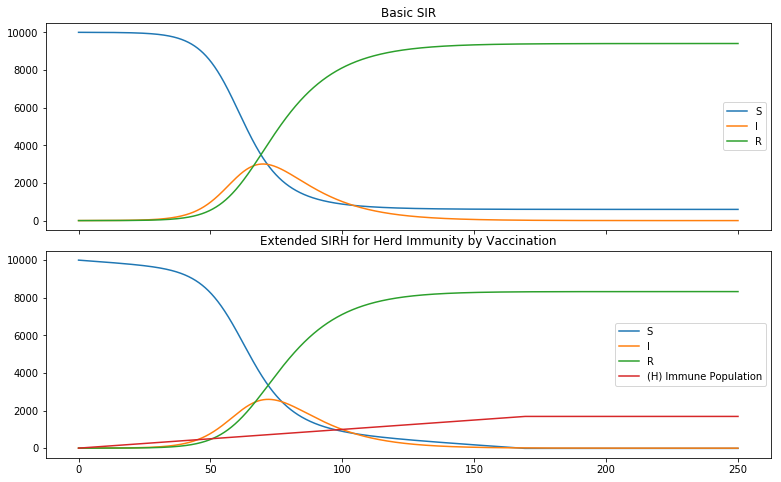

In [5]:
#### Plot comparison. 

# Ill use initial condiitons from lab notebook for comparison 
I0 = 1
N = 10000
k = 3/14
g = 1/14
dt = 0.01
duration = 250 #days

v = N*0.001 # one percent of population vaccinated per day 

S, I ,R = SIR_noR0(I0, N, k, g, dt, duration) # plot old basic SIR to compare
time = np.linspace(0, len(S)*dt, len(S))

plt.rcParams['figure.figsize'] = [13, 8]

fig1, axs1 = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1})

axs1[0].plot(time, S, label = "S")
axs1[0].plot(time, I, label = "I")
axs1[0].plot(time, R, label = "R")
axs1[0].legend()
axs1[0].set_title("Basic SIR")

Se, Ie, Re, He = SIRH(I0, N, k, g, v, dt, duration) # extended model with basic vaccination rate 
print(Se)
print(CheckTotal(Se, Ie, Re, He, N))
    
axs1[1].plot(time, Se, label = "S")
axs1[1].plot(time, Ie, label = "I")
axs1[1].plot(time, Re, label = "R")
axs1[1].plot(time, He, label = "(H) Immune Population")
axs1[1].legend()
axs1[1].set_title("Extended SIRH for Herd Immunity by Vaccination")

I will introduce a lag time for the vaccine and a range for the vaccination rate to make this more realistic. 

True


Text(0.5, 1.0, 'Extended SIRH for Herd Immunity by Vaccination')

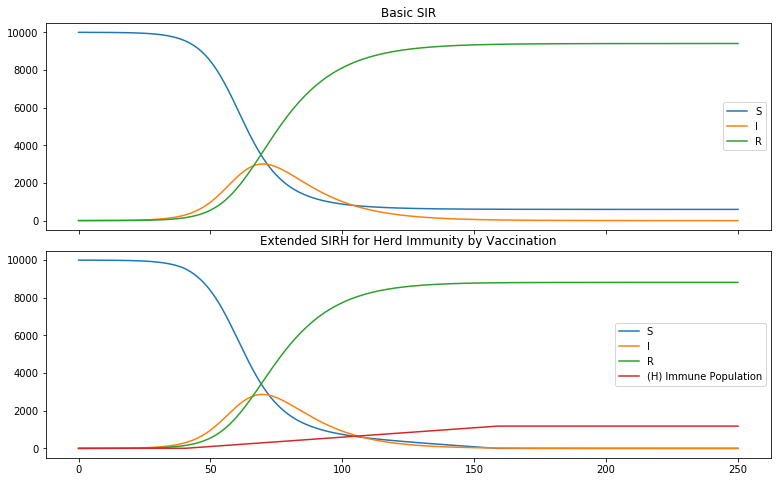

In [6]:
### modify SIRH to make more realistic

def SIRH(I0, N, k, g, v, lag, dt, duration):
    j = int(duration/dt)
    time_elapsed = 0 # go for duration, iterating by dt
    I, S, R, H = np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j) # i will iterate and fill these in with values 
    R[0] = g*I0 # set initial values as given. 
    I[0] = I0
    S[0] = N-1
    H[0] = 0 # starts with no people vaccinated
    for i in range(1, j): # increment SIR by dt. eg X(t+dt) = X(t) + dX. Log totals in the arrays. 
        dR = g*I[i-1]*dt # get dX values from equation 6
        dI = ((k/N)*S[i-1]*I[i-1]-g*I[i-1])*dt
        if i*dt > lag:  # introduce number of days into pandemic it takes to get vaccinations going 
            since_vacc = i*dt -lag
            
            if (S[i-1]) < 0: # if there are still unvaccinated people
                S[i-1] = 0
                H[i-1] = H[i-2]
                dS = 0
                dH = 0
            else:
                dH = v*dt
                dS = -(k/N) * S[i-1]*I[i-1]*dt - v*dt
        else: 
            dS = -(k/N) * S[i-1]*I[i-1]*dt 
            dH = 0
        I[i] = I[i-1]+dI  # add increment to last value X(t) to get X(t+dt)
        R[i] = R[i-1]+dR
        S[i] = S[i-1]+dS
        H[i] = H[i-1]+dH # linearly remove vaccined population, which is limited by number of vaccines given per day
    return S, I, R, H  # return S, I, and R arrays indexed by time.


fig2, axs2 = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1})

axs2[0].plot(time, S, label = "S")
axs2[0].plot(time, I, label = "I")
axs2[0].plot(time, R, label = "R")
axs2[0].legend()
axs2[0].set_title("Basic SIR")

lag = 40 # took 200 days into 250 day pandemic to introduce vaccine. 

Se, Ie, Re, He = SIRH(I0, N, k, g, v, lag, dt, duration) # extended model with basic vaccination rate 
print(CheckTotal(He, Se, Ie, Re, N))
    
axs2[1].plot(time, Se, label = "S")
axs2[1].plot(time, Ie, label = "I")
axs2[1].plot(time, Re, label = "R")
axs2[1].plot(time, He, label = "(H) Immune Population")
axs2[1].legend()
axs2[1].set_title("Extended SIRH for Herd Immunity by Vaccination")


Incorperate current state to predict how long after vaccination pandemic goes away. 

Next I want to add a function so that the vaccination rate is going up logarithmically, so that it asyptomptotically stops at a certain rate. This basically models real life with the vaccination rates increasing with availability then capping off at manufacturing and adminstrative capacity. 

True


Text(0.5, 1.0, 'Extended SIRH for Herd Immunity by Vaccination')

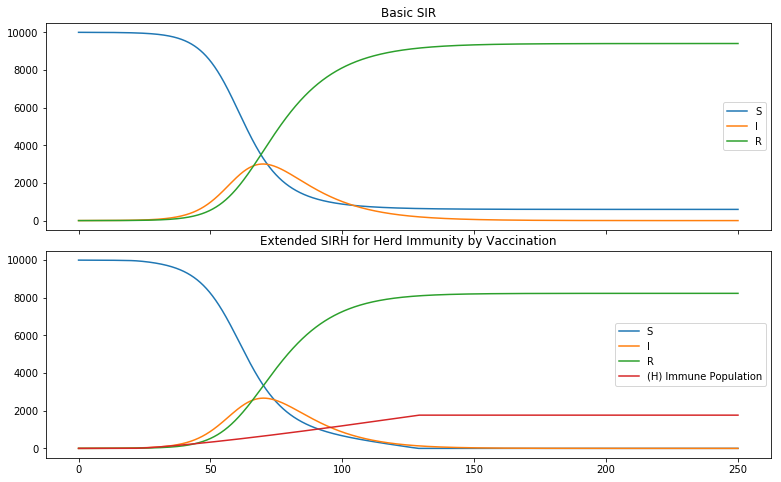

In [7]:

def SIRH(I0, N, k, g, v, lag, dt, duration):
    j = int(duration/dt)
    time_elapsed = 0 # go for duration, iterating by dt
    I, S, R, H = np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j) # i will iterate and fill these in with values 
    R[0] = g*I0 # set initial values as given. 
    I[0] = I0
    S[0] = N-1
    H[0] = 0 # starts with no people vaccinated
    for i in range(1, j): # increment SIR by dt. eg X(t+dt) = X(t) + dX. Log totals in the arrays. 
        dR = g*I[i-1]*dt # get dX values from equation 6
        dI = ((k/N)*S[i-1]*I[i-1]-g*I[i-1])*dt
        if i*dt > lag:  # introduce number of days into pandemic it takes to get vaccinations going 
            since_vacc = i*dt -lag
            vr = v*math.log(since_vacc+1, 10) # the amount of people vaccined per day is more of a logarithmic increase rather than linear  
            if (S[i-1]) < 0: # if there are still unvaccinated people
                S[i-1] = 0
                H[i-1] = H[i-2]
                dS = 0
                dH = 0
            else:
                dH = vr*dt
                dS = -(k/N) * S[i-1]*I[i-1]*dt - vr*dt
        else: 
            dS = -(k/N) * S[i-1]*I[i-1]*dt 
            dH = 0
        I[i] = I[i-1]+dI  # add increment to last value X(t) to get X(t+dt)
        R[i] = R[i-1]+dR
        S[i] = S[i-1]+dS
        H[i] = H[i-1]+dH # linearly remove vaccined population, which is limited by number of vaccines given per day
    return S, I, R, H  # return S, I, and R arrays indexed by time.

fig3, axs3 = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1})

axs3[0].plot(time, S, label = "S")
axs3[0].plot(time, I, label = "I")
axs3[0].plot(time, R, label = "R")
axs3[0].legend()
axs3[0].set_title("Basic SIR")

lag = 20 # took 200 days into 250 day pandemic to introduce vaccine. 

Se, Ie, Re, He = SIRH(I0, N, k, g, v, lag, dt, duration) # extended model with basic vaccination rate 
print(CheckTotal(He, Se, Ie, Re, N))
    
axs3[1].plot(time, Se, label = "S")
axs3[1].plot(time, Ie, label = "I")
axs3[1].plot(time, Re, label = "R")
axs3[1].plot(time, He, label = "(H) Immune Population")
axs3[1].legend()
axs3[1].set_title("Extended SIRH for Herd Immunity by Vaccination")


### [RN] 1:23 pm 

Realisticaly, there is a small percent of people who will not be vaccinated. I will introduce "A" for anti-vax, which is a percent of the population that will remain in the susceptible pool and never recieve a vaccination. 

Also, recoverd people should be divided up as well. After being infected; a person will either die (D), have temporary immunity (T). People who have temporary immunity may get vaccinated but are not susceptible again for a certain amount of time. People with temporary immunity (T) will be readded to S if not vaccinated after they have been temporarily immune for "w" days 

$\frac{dD}{dt} = d*R$
$\frac{dT}{dt} = R-D$ 
I am going to assume that people from the temporarily immune and susceptible group are equally as likely to get vaccined. 



True


Text(0.5, 1.0, 'Extended SIRH for Herd Immunity by Vaccination')

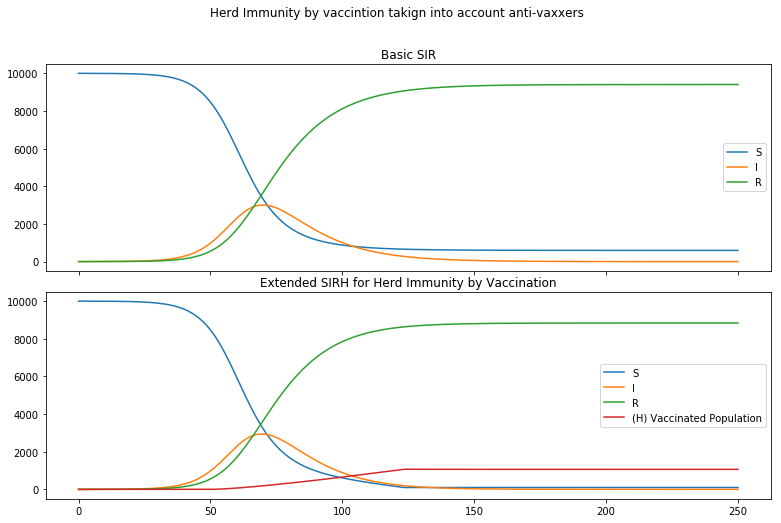

In [8]:
### start wiht just anti vax. 

def SIRH(I0, N, k, g, v, lag, A, dt, duration): # susceptible, infected, temporarily immune, dead, herd immune
    j = int(duration/dt)
    time_elapsed = 0 # go for duration, iterating by dt
    I, S, R, H = np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j) # i will iterate and fill these in with values 
    R[0] = g*I0 # set initial values as given. 
    I[0] = I0
    S[0] = N-1
    H[0] = 0 # starts with no people vaccinated
    for i in range(1, j): # increment SIR by dt. eg X(t+dt) = X(t) + dX. Log totals in the arrays. 
        dR = g*I[i-1]*dt # get dX values from equation 6
        dI = ((k/N)*S[i-1]*I[i-1]-g*I[i-1])*dt
        if i*dt > lag:  # introduce number of days into pandemic it takes to get vaccinations going 
            since_vacc = i*dt -lag
            vr = v*math.log(since_vacc+1, 10) # the amount of people vaccined per day is more of a logarithmic increase rather than linear  
            if (S[i-1]) < A*N: # if there are still unvaccinated people
                S[i-1] = A*N
                H[i-1] = N - S[i-1] - I[i-1] - R[i-1]
                dS = 0
                dH = 0
            else:
                dH = vr*dt
                dS = -(k/N) * S[i-1]*I[i-1]*dt - vr*dt
        else: 
            dS = -(k/N) * S[i-1]*I[i-1]*dt 
            dH = 0
        I[i] = I[i-1]+dI  # add increment to last value X(t) to get X(t+dt)
        R[i] = R[i-1]+dR
        S[i] = S[i-1]+dS
        H[i] = H[i-1]+dH # linearly remove vaccined population, which is limited by number of vaccines given per day
    return S, I, R, H  # return S, I, and R arrays indexed by time.


fig4, axs4 = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1})
fig4.suptitle("Herd Immunity by vaccintion takign into account anti-vaxxers")
axs4[0].plot(time, S, label = "S")
axs4[0].plot(time, I, label = "I")
axs4[0].plot(time, R, label = "R")
axs4[0].legend()
axs4[0].set_title("Basic SIR")

lag = 50 # took 200 days into 250 day pandemic to introduce vaccine. 

A = 0.01 # % of the population will not get the vaccine for whatever reason 

Se, Ie, Re, He = SIRH(I0, N, k, g, v, lag, A, dt, duration) # extended model with basic vaccination rate 
print(CheckTotal(He, Se, Ie, Re, N))
    
axs4[1].plot(time, Se, label = "S")
axs4[1].plot(time, Ie, label = "I")
axs4[1].plot(time, Re, label = "R")
axs4[1].plot(time, He, label = "(H) Vaccinated Population")
axs4[1].legend()
axs4[1].set_title("Extended SIRH for Herd Immunity by Vaccination")

True
[0.00000000e+00 1.42857143e-05 2.85918337e-05 ... 1.76729123e+02
 1.76729124e+02 1.76729124e+02]


Text(0.5, 1.0, 'Extended SIRH for Herd Immunity by Vaccination')

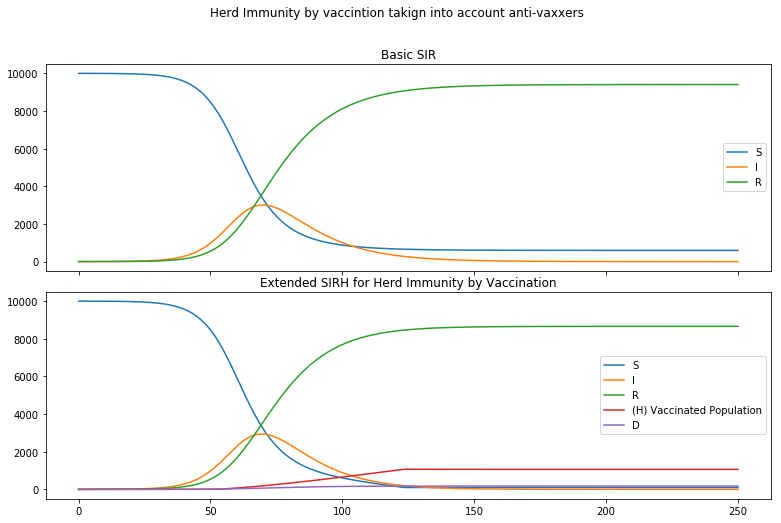

In [9]:
### add death rate  

def SIRHD(I0, N, k, g, v, lag, A, d, dt, duration): # susceptible, infected, temporarily immune, dead, herd immune
    j = int(duration/dt)
    time_elapsed = 0 # go for duration, iterating by dt
    I, S, R, H, D = np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j) # i will iterate and fill these in with values 
    R[0] = g*I0 # set initial values as given. 
    I[0] = I0
    S[0] = N-1
    H[0] = 0 # starts with no people vaccinated
    D[0] = 0
    for i in range(1, j): # increment SIR by dt. eg X(t+dt) = X(t) + dX. Log totals in the arrays. 
        dR = g*I[i-1]*dt # get dX values from equation 6
        dI = ((k/N)*S[i-1]*I[i-1]-g*I[i-1])*dt
        if i*dt > lag:  # introduce number of days into pandemic it takes to get vaccinations going 
            since_vacc = i*dt -lag
            vr = v*math.log(since_vacc+1, 10) # the amount of people vaccined per day is more of a logarithmic increase rather than linear  
            if (S[i-1]) < A*N: # if there are still unvaccinated people
                S[i-1] = A*N
                H[i-1] = N - S[i-1] - I[i-1] - R[i-1]-D[i-1]
                dS = 0
                dH = 0
            else:
                dH = vr*dt
                dS = -(k/N) * S[i-1]*I[i-1]*dt - vr*dt
        else: 
            dS = -(k/N) * S[i-1]*I[i-1]*dt 
            dH = 0
        dD = dR*d # amount of dead people in this time step 
        dR = dR - dD # remove dead population from initially calculated recovered 
        I[i] = I[i-1]+dI  # add increment to last value X(t) to get X(t+dt)
        R[i] = R[i-1]+dR
        D[i] = D[i-1]+dD
        S[i] = S[i-1]+dS
        H[i] = H[i-1]+dH # linearly remove vaccined population, which is limited by number of vaccines given per day
    return S, I, R, H, D # return S, I, and R arrays indexed by time.


fig4, axs4 = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1})
fig4.suptitle("Herd Immunity by vaccintion takign into account anti-vaxxers")
axs4[0].plot(time, S, label = "S")
axs4[0].plot(time, I, label = "I")
axs4[0].plot(time, R, label = "R")
axs4[0].legend()
axs4[0].set_title("Basic SIR")

lag = 50 # took 200 days into 250 day pandemic to introduce vaccine. 

A = 0.01 # % of the population will not get the vaccine for whatever reason 

def CheckTotal(S, I, R, H, D, N): 
    nonN = 0
    for i in range(len(S)):
        total = S[i] + I[i] + R[i] + H[i] + D[i]
        if round(total, 0) != N:
            nonN = nonN+1
    if nonN == 0:
        return True # SIR all add up to N at any given time
    else:
        return False # something went wrong. total is not N.

d = 0.02 # death rate :/
Se, Ie, Re, He, De = SIRHD(I0, N, k, g, v, lag, A, d, dt, duration) # extended model with basic vaccination rate 
print(CheckTotal(He, Se, Ie, Re, De, N))
print(De)
axs4[1].plot(time, Se, label = "S")
axs4[1].plot(time, Ie, label = "I")
axs4[1].plot(time, Re, label = "R")
axs4[1].plot(time, He, label = "(H) Vaccinated Population")
axs4[1].plot(time, De, label = "D")
axs4[1].legend()
axs4[1].set_title("Extended SIRH for Herd Immunity by Vaccination")

### [RN] 1:58
Death rate looks right, next step is to add back some of the removed population over time to susceptible and make it possible for removed population to get vaccinated and join H

I have to go to work now, maybe will come back to this later. 

Or now becuase my office hours are slow! 




/Users/rebeccanishide/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


30000 30000
True
[9999.         9998.99785736 9998.99571165 ...  962.35950563  962.29972759
  962.23994933]
Basic SIR max I:  3749.4414282934713 , Extended SIR max I:  2582.029209440708


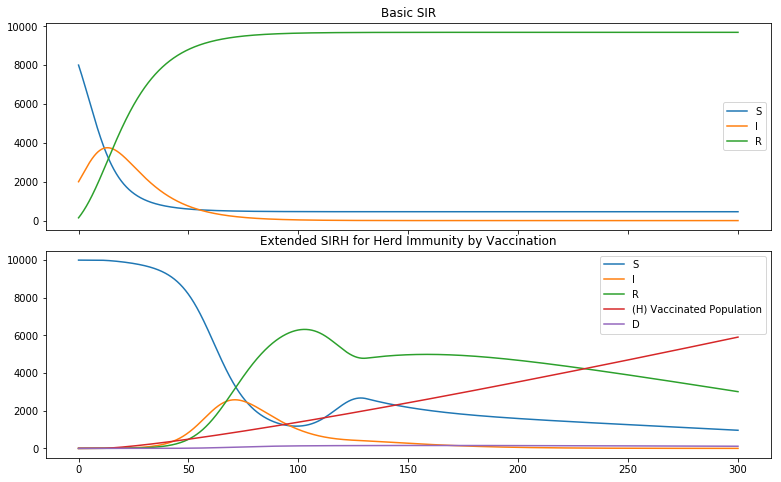

In [16]:
### add temporary immunity and vaccines for recovered population 

def SIRHD(I0, N, k, g, v, lag, A, d, w, dt, duration): # susceptible, infected, temporarily immune, dead, herd immune
    j = int(duration/dt)
    time_elapsed = 0 # go for duration, iterating by dt
    I, S, R, H, D = np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j) # i will iterate and fill these in with values 
    IPD = np.zeros(j) # infected per day
    R[0] = g*I0 # set initial values as given. 
    I[0] = I0
    S[0] = N-I0
    H[0] = 0 # starts with no people vaccinated
    D[0] = 0
    IPD[0] = 0
    for i in range(1, j): # increment SIR by dt. eg X(t+dt) = X(t) + dX. Log totals in the arrays. 
        dR = g*I[i-1]*dt # get dX values from equation 6
        dI = ((k/N)*S[i-1]*I[i-1]-g*I[i-1])*dt
        if i*dt > lag:  # introduce number of days into pandemic it takes to get vaccinations going 
            since_vacc = i*dt -lag
            vr = v*math.log(since_vacc+1, 10) # the amount of people vaccined per day is more of a logarithmic increase rather than linear  
            if (S[i-1]+R[i-1]+D[i-1]) < A*N: # if there are no unvaccinated people
                S[i-1] = A*N
                H[i-1] = N - S[i-1] - I[i-1] - R[i-1]-D[i-1]
                dS = 0
                dH = 0
            else:
                pool = S[i-1] + R[i-1]
                wS = S[i-1]/pool # weight R and S groups to remove vaccined group
                wR = R[i-1]/pool # R and S people have equal probability of being vaccinated 
                dH = vr*dt
                dS = -(k/N) * S[i-1]*I[i-1]*dt - vr*dt*wS
                dR = dR - vr*dt*wR
        else: 
            dS = -(k/N) * S[i-1]*I[i-1]*dt 
            dH = 0
        if i*dt> w: # w is the number of days after recovery a person becomes susceptible again 
            entry_point = i - int(w/dt)
            reentry = IPD[entry_point]
            if reentry < 0: 
                    reentry = 0
        else: 
            reentry = 0
        dD = dR*d # amount of dead people in this time step 
        dR = dR - dD - reentry # remove dead population from initially calculated recovered 
        dS = dS + reentry
        IPD[i] = dI
        I[i] = I[i-1]+dI  # add increment to last value X(t) to get X(t+dt)
        R[i] = R[i-1]+dR
        D[i] = D[i-1]+dD
        S[i] = S[i-1]+dS
        H[i] = H[i-1]+dH # linearly remove vaccined population, which is limited by number of vaccines given per day
    return S, I, R, H, D # return S, I, and R arrays indexed by time.

duration = 300
time = np.linspace(0, duration, duration/dt)
S, I ,R = SIR_noR0(I0, N, k, g, dt, duration) # plot old basic SIR to compare
print(len(time), len(S))
fig5, axs5 = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1})
fig4.suptitle("Herd Immunity by vaccintion takign into account anti-vaxxers")
axs5[0].plot(time, S, label = "S")
axs5[0].plot(time, I, label = "I")
axs5[0].plot(time, R, label = "R")
axs5[0].legend()
axs5[0].set_title("Basic SIR")
I0 = 1
N = 10000
lag = 10 # took 200 days into 250 day pandemic to introduce vaccine. 

A = 0.01 # % of the population will not get the vaccine for whatever reason 

w = 60 

d = 0.02 # death rate :/
Se, Ie, Re, He, De = SIRHD(I0, N, k, g, v, lag, A, d, w, dt, duration) # extended model with basic vaccination rate 
print(CheckTotal(He, Se, Ie, Re, De, N))
print(Se)
axs5[1].plot(time, Se, label = "S")
axs5[1].plot(time, Ie, label = "I")
axs5[1].plot(time, Re, label = "R")
axs5[1].plot(time, He, label = "(H) Vaccinated Population")
axs5[1].plot(time, De, label = "D")
axs5[1].legend()
axs5[1].set_title("Extended SIRH for Herd Immunity by Vaccination")

print("Basic SIR max I: ", max(I), ", Extended SIR max I: ", max(Ie))

### [RN] 2:23 

This looks pretty good to me. I will use intitial conditions extracted from data to use my SIR to project. Katherines analysis of papers and real data will be fed to this model to make the vaccination rates realistic, and evaluat our approach relative to published ones. 

It is a bit hard to see values when they are lower so I will plot logarihtmically. I am also curious what happens if you start at a high I0, like I will be to project using real data. 

Text(0.5, 1.0, 'Extended SIRH for Herd Immunity by Vaccination, logarithmic scale')

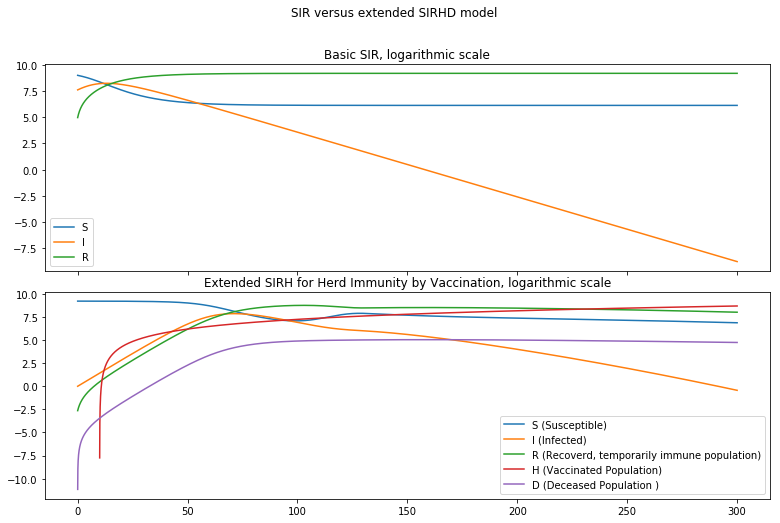

In [14]:
### logarithmic plots 

def LnData(dat):   # I coped this from 20210131 notebook
    lndat = np.zeros(len(dat))
    for i in range(len(dat)):
        try:
            lndat[i] = math.log(dat[i])
        except:
            lndat[i] = None
    return lndat

LnS = LnData(S)
LnI = LnData(I)
LnR = LnData(R)

LnSe = LnData(Se)
LnIe = LnData(Ie)
LnRe = LnData(Re)
LnHe = LnData(He)
LnDe = LnData(De)

fig6, axs6 = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1})
fig6.suptitle("SIR versus extended SIRHD model ")
axs6[0].plot(time, LnS, label = "S")
axs6[0].plot(time, LnI, label = "I")
axs6[0].plot(time, LnR, label = "R")
axs6[0].legend()
axs6[0].set_title("Basic SIR, logarithmic scale")

axs6[1].plot(time, LnSe, label = "S (Susceptible)")
axs6[1].plot(time, LnIe, label = "I (Infected)")
axs6[1].plot(time, LnRe, label = "R (Recoverd, temporarily immune population)")
axs6[1].plot(time, LnHe, label = "H (Vaccinated Population)")
axs6[1].plot(time, LnDe, label = "D (Deceased Population )")
axs6[1].legend()
axs6[1].set_title("Extended SIRH for Herd Immunity by Vaccination, logarithmic scale")


Ok the logarithmic scale does not really show much. I will check high I0 and be done for the day. 

30000 30000
False
[8000.         7996.57142857 7993.14089943 ...  795.02476867  794.97736097
  794.92995303]
Basic SIR max I:  3749.4414282934713 , Extended SIR max I:  3748.835516342065


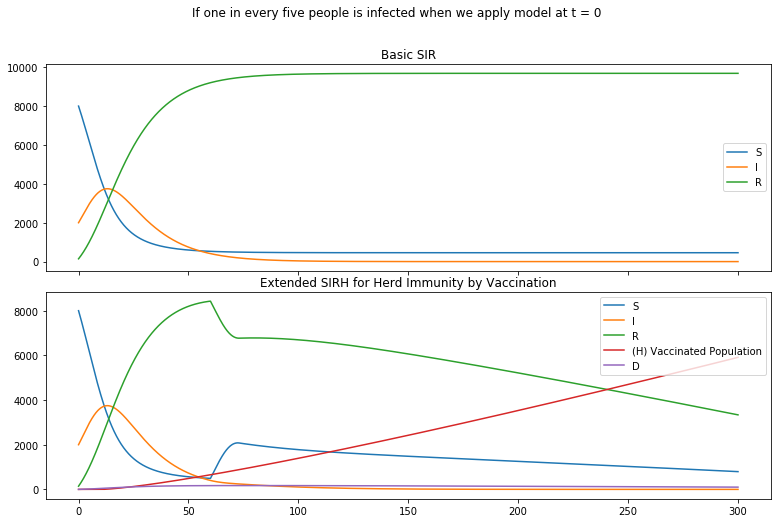

In [15]:
N = 10000
I0 = N * 0.2 # lets say we start with one in five people infected. 

S, I ,R = SIR_noR0(I0, N, k, g, dt, duration) # plot old basic SIR to compare
print(len(time), len(S))
fig6, axs6 = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1})
fig6.suptitle("If one in every five people is infected when we apply model at t = 0")
axs6[0].plot(time, S, label = "S")
axs6[0].plot(time, I, label = "I")
axs6[0].plot(time, R, label = "R")
axs6[0].legend()
axs6[0].set_title("Basic SIR")

lag = 10 # took 200 days into 250 day pandemic to introduce vaccine. 

A = 0.01 # % of the population will not get the vaccine for whatever reason 

w = 60 

d = 0.02 # death rate :/
Se, Ie, Re, He, De = SIRHD(I0, N, k, g, v, lag, A, d, w, dt, duration) # extended model with basic vaccination rate 
print(CheckTotal(He, Se, Ie, Re, De, N))
print(Se)
axs6[1].plot(time, Se, label = "S")
axs6[1].plot(time, Ie, label = "I")
axs6[1].plot(time, Re, label = "R")
axs6[1].plot(time, He, label = "(H) Vaccinated Population")
axs6[1].plot(time, De, label = "D")
axs6[1].legend()
axs6[1].set_title("Extended SIRH for Herd Immunity by Vaccination")

print("Basic SIR max I: ", max(I), ", Extended SIR max I: ", max(Ie))

### [RN] 2:50 pm 
To extend the fit I will need to play with parameters to get the SIR to fit the current curve and then project the future. One way to do this would be to fit I to data and then let the other parameters run with the differential equations. The biggest issue here is that we are starting with an infected population but removal does not start until after w days. Finally, I will run for many days to see what happens when everyone is finally vaccinated. 

# Summarize  tentative final extension

/Users/rebeccanishide/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


73000 73000
True
[9999.         9998.99785736 9998.99571165 ...   67.13790293   66.85211061
   66.56631769]
Basic SIR max I:  3005.7835701029644 , Extended SIR max I:  2582.029209440708


Text(0.5, 0.98, 'Number of Infections predicted by different models')

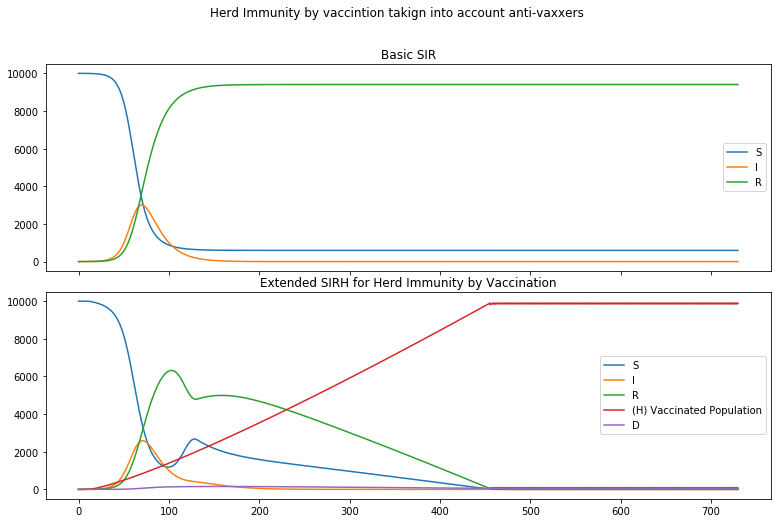

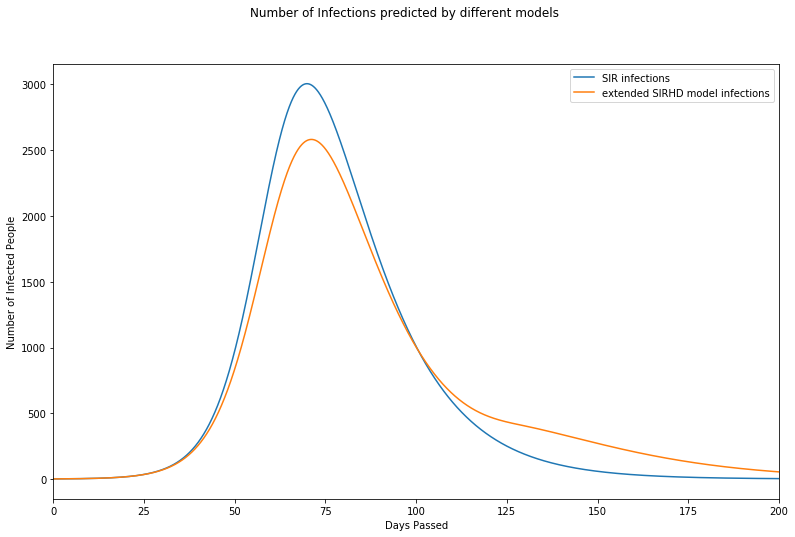

In [21]:
duration = 365*2 # two years 
time = np.linspace(0, duration, duration/dt)
I0 = 1
N = 10000
lag = 10 # took 200 days into 250 day pandemic to introduce vaccine. 

A = 0.01 # % of the population will not get the vaccine for whatever reason 

w = 60 
R0 = k/g
HIT = 1-(1/R0)

S, I ,R = SIR_noR0(I0, N, k, g, dt, duration) # plot old basic SIR to compare
print(len(time), len(S))
fig7, axs7 = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1})
fig7.suptitle("Herd Immunity by vaccintion takign into account anti-vaxxers")
axs7[0].plot(time, S, label = "S")
axs7[0].plot(time, I, label = "I")
axs7[0].plot(time, R, label = "R")
axs7[0].legend()
axs7[0].set_title("Basic SIR")

d = 0.02 # death rate :/
Se, Ie, Re, He, De = SIRHD(I0, N, k, g, v, lag, A, d, w, dt, duration) # extended model with basic vaccination rate 
print(CheckTotal(He, Se, Ie, Re, De, N))
print(Se)
axs7[1].plot(time, Se, label = "S")
axs7[1].plot(time, Ie, label = "I")
axs7[1].plot(time, Re, label = "R")
axs7[1].plot(time, He, label = "(H) Vaccinated Population")
axs7[1].plot(time, De, label = "D")
axs7[1].legend()
axs7[1].set_title("Extended SIRH for Herd Immunity by Vaccination")

print("Basic SIR max I: ", max(I), ", Extended SIR max I: ", max(Ie))

fig8, axs8 = plt.subplots() # I want a plot to show the change in I with the SIR and SIHR 
axs8.plot(time, I, label = "SIR infections ")
axs8.plot(time, Ie, label = "extended SIRHD model infections")
plt.xlim(0, 200)
plt.xlabel("Days Passed")
plt.ylabel("Number of Infected People")
plt.legend()
fig8.suptitle("Number of Infections predicted by different models")

My model widens the curve and adds a tail becuase the recovered people are re-added to the pool and are viable for removal by vaccination to model herd immunity. Due to the vaccine, the curve is also slightly flattened. 

It basically looks like this data accelerates the process too fast compared to real data. We are still on the up. I think I can fit the infections to real data and then model around that to project. I will leave parameters like vaccination rate and death rates open so that me and Katherine can integrate our components of this project. 

Below is my final SIRHD function

In [22]:
## final function. 

"""
Input arguements 
I0 : initial number of infected peopl e
N : population size 
k : number of people each infected person infects 
g : removal rate from infectious pool 
v : vaccination constant, fit for vaccines given for the nth day, n=0 for first day vaccine is available is v*log(day)
lag : Number of days after patient 0, or day 0, after which vaccine becomes available
A : Anti vax population, or a percent of the population that will refuse the vaccine 
d : death rate, or percept of recovered people who are actually dead and removed completely 
w : number of days after infection that a person is temporarily immune and in recovered pool before being moved back to susceptible
dt : time step. this is moderately sensitive to time step, see 20210205 notebook 
duration : number of days that should be modeled 

Outputs (arrays indexed by time): 
S : population susceptible to infection, and viable for vaccination 
I : Infected population 
R : recovered population, temporarily immine and viable for vaccination 
H : immune population, shows herd immunity through vaccination. Once vaccinated you are permanently immune by this extension
D : Dead population 
"""
def SIRHD(I0, N, k, g, v, lag, A, d, w, dt, duration): # susceptible, infected, temporarily immune, dead, herd immune
    j = int(duration/dt)
    time_elapsed = 0 # go for duration, iterating by dt
    I, S, R, H, D = np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j) # i will iterate and fill these in with values 
    IPD = np.zeros(j) # infected per day
    R[0] = g*I0 # set initial values as given. 
    I[0] = I0
    S[0] = N-I0
    H[0] = 0 # starts with no people vaccinated
    D[0] = 0
    IPD[0] = 0
    for i in range(1, j): # increment SIR by dt. eg X(t+dt) = X(t) + dX. Log totals in the arrays. 
        dR = g*I[i-1]*dt # get dX values from equation 6
        dI = ((k/N)*S[i-1]*I[i-1]-g*I[i-1])*dt
        if i*dt > lag:  # introduce number of days into pandemic it takes to get vaccinations going 
            since_vacc = i*dt -lag
            vr = v*math.log(since_vacc+1, 10) # the amount of people vaccined per day is more of a logarithmic increase rather than linear  
            if (S[i-1]+R[i-1]+D[i-1]) < A*N: # if there are no unvaccinated people
                S[i-1] = A*N
                H[i-1] = N - S[i-1] - I[i-1] - R[i-1]-D[i-1]
                dS = 0
                dH = 0
            else:
                pool = S[i-1] + R[i-1]
                wS = S[i-1]/pool # weight R and S groups to remove vaccined group
                wR = R[i-1]/pool # R and S people have equal probability of being vaccinated 
                dH = vr*dt
                dS = -(k/N) * S[i-1]*I[i-1]*dt - vr*dt*wS
                dR = dR - vr*dt*wR
        else: 
            dS = -(k/N) * S[i-1]*I[i-1]*dt 
            dH = 0
        if i*dt> w: # w is the number of days after recovery a person becomes susceptible again 
            entry_point = i - int(w/dt)
            reentry = IPD[entry_point]
            if reentry < 0: 
                    reentry = 0
        else: 
            reentry = 0
        dD = dR*d # amount of dead people in this time step 
        dR = dR - dD - reentry # remove dead population from initially calculated recovered 
        dS = dS + reentry
        IPD[i] = dI
        I[i] = I[i-1]+dI  # add increment to last value X(t) to get X(t+dt)
        R[i] = R[i-1]+dR
        D[i] = D[i-1]+dD
        S[i] = S[i-1]+dS
        H[i] = H[i-1]+dH # linearly remove vaccined population, which is limited by number of vaccines given per day
    return S, I, R, H, D # return S, I, and R arrays indexed by time.